<h1> Background </h1>

Cardiovascular diseases (CVDs) are the number 1 cause of death globally, taking an estimated 17.9 million lives each year, which accounts for 31% of all deaths worldwide. Four out of 5CVD deaths are due to heart attacks and strokes, and one-third of these deaths occur prematurely in people under 70 years of age. Heart failure is a common event caused by CVDs and this dataset contains 11 features that can be used to predict a possible heart disease.

People with cardiovascular disease or who are at high cardiovascular risk (due to the presence of one or more risk factors such as hypertension, diabetes, hyperlipidaemia or already established disease) need early detection and management wherein a machine learning model can be of great help.
<br>

Src : https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction

<h1> Dataset </h1>
The dataset is as follows:
1 - Age: age of the patient [years] <br> <br>
2 - Sex: sex of the patient [M: Male, F: Female] <br> <br>
3 - ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP:  Non-Anginal 4Pain, ASY: Asymptomatic] <br> <br>
5 - RestingBP: resting blood pressure [mm Hg] <br> <br>
6 - Cholesterol: serum cholesterol [mm/dl] <br> <br>
7 - FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise] <br> <br>
8 - RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave 9 9 9 abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria] <br><br>
9 - MaxHR: maximum heart rate achieved [Numeric value between 60 and 202] <br><br>
10 - ExerciseAngina: exercise-induced angina [Y: Yes, N: No] <br><br>
11 - Oldpeak: oldpeak = ST [Numeric value measured in depression] <br><br>
12 - ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping] <br><br>
13 - HeartDisease: output class [1: heart disease, 0: Normal]

Src : https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction

<h1> Objective </h1>

Our goal is to predict the presence of heart disease in a patient based on the given features. We will use a variety of machine learning models to predict the presence of heart disease in a patient and compare the performance of these models.

<h1> 0 - Notebook preparation </h1>

<h2> 0.1 - packages installation </h2>

In [161]:
!pip install kagglehub
!pip install scipy
!pip install seaborn
!pip install statsmodels
!pip install ipympl
!pip install scikit-learn-extra

<h2> 0.2 - Imports </h2>

In [162]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.decomposition import PCA
from scipy.stats import chi2_contingency, pointbiserialr
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn_extra.cluster import KMedoids
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

<h2> 0.3 - Dataset path </h2>

In [163]:

if 'vscode' in sys.modules:
    DATASET_PATH = './heart.csv'
elif 'google.colab' in sys.modules:
    dataset_folder = kagglehub.dataset_download('fedesoriano/heart-failure-prediction')
    DATASET_PATH = os.path.join(dataset_folder, 'heart.csv')
else:
    raise Exception('Unknown environment')

<h2> 0.4 - Global settings </h2>

In [164]:
pd.set_option('display.float_format', '{:.2f}'.format)
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
GROUND_TRUTH_CLUSTERS_FIG = 'clusters.png'
KMEANS_FIG = 'kmeans.png'
KMOIEDS_FIG = 'kmedoids.png'
AGGLOMERATIVE_FIG = 'agglomerative.png'

<h2> 0.5 - Functions </h2>

In [165]:
def display_clusters_for_2_components(pca_components, y, cluster_obj, title, save_fig_path):
    plt.figure(figsize=(10, 10))
    plt.scatter(pca_components.iloc[y == 0, 0], pca_components.iloc[y == 0, 1], s=100, c='red', label='Cluster 1')
    plt.scatter(pca_components.iloc[y == 1, 0], pca_components.iloc[y == 1, 1], s=100, c='blue', label='Cluster 2')
    plt.scatter(cluster_obj.cluster_centers_[:, 0], cluster_obj.cluster_centers_[:, 1], s=300, c='yellow', label='Centroids')
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.savefig(save_fig_path)
    plt.show()


def display_clusters_for_3_components(pca_components, y, cluster_obj, title, save_fig_path):
    fig = plt.figure(figsize=(13, 13))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pca_components.iloc[y == 0, 0], pca_components.iloc[y == 0, 1], pca_components.iloc[y == 0, 2], s=100, c='red', label='Cluster 1')
    ax.scatter(pca_components.iloc[y == 1, 0], pca_components.iloc[y == 1, 1], pca_components.iloc[y == 1, 2], s=100, c='blue', label='Cluster 2')
    ax.scatter(cluster_obj.cluster_centers_[:, 0], cluster_obj.cluster_centers_[:, 1], cluster_obj.cluster_centers_[:, 2], s=300)
    ax.set_title(title)
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    ax.legend()
    plt.savefig(save_fig_path)
    plt.show()

def display_clusters_plt(pca_components, clusters, algorithm_obj, title, save_fig_path):
    if pca_components.shape[1] == 2:
        display_clusters_for_2_components(pca_components, clusters, algorithm_obj, title, save_fig_path)
    elif pca_components.shape[1] == 3:
        display_clusters_for_3_components(pca_components, clusters, algorithm_obj, title, save_fig_path)
    else:
        raise Exception('Unsupported number of components')

<h1> 1 - Data Exploration and visualization </h1>

<h2> 1.1 - Overview (first part) </h2>

In [166]:
df = pd.read_csv(DATASET_PATH)
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.00,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.00,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.00,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.50,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.00,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.20,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.40,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.20,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.00,Flat,1


<h2> 1.2 - Overview (second part)</h2>

In [167]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.00,918.00,918.00,918.00,918.00,918.00,918.00
mean,53.51,132.40,198.80,0.23,136.81,0.89,0.55
std,9.43,18.51,109.38,0.42,25.46,1.07,0.50
min,28.00,0.00,0.00,0.00,60.00,-2.60,0.00
25%,47.00,120.00,173.25,0.00,120.00,0.00,0.00
50%,54.00,130.00,223.00,0.00,138.00,0.60,1.00
75%,60.00,140.00,267.00,0.00,156.00,1.50,1.00
max,77.00,200.00,603.00,1.00,202.00,6.20,1.00


<h2> 1.3 - Frequency plot & histogram </h2>

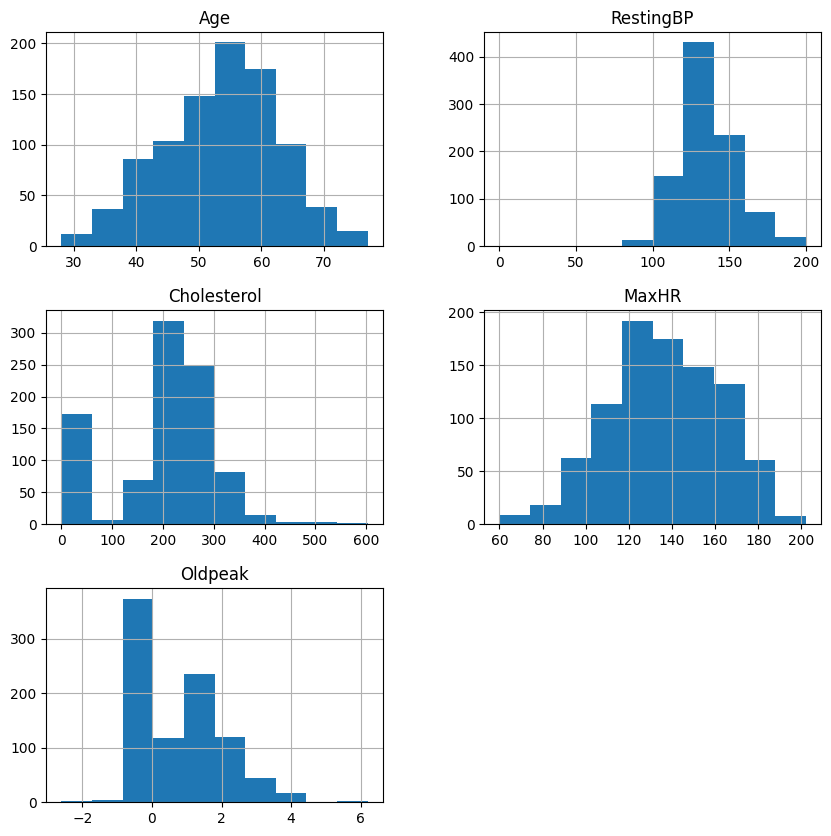

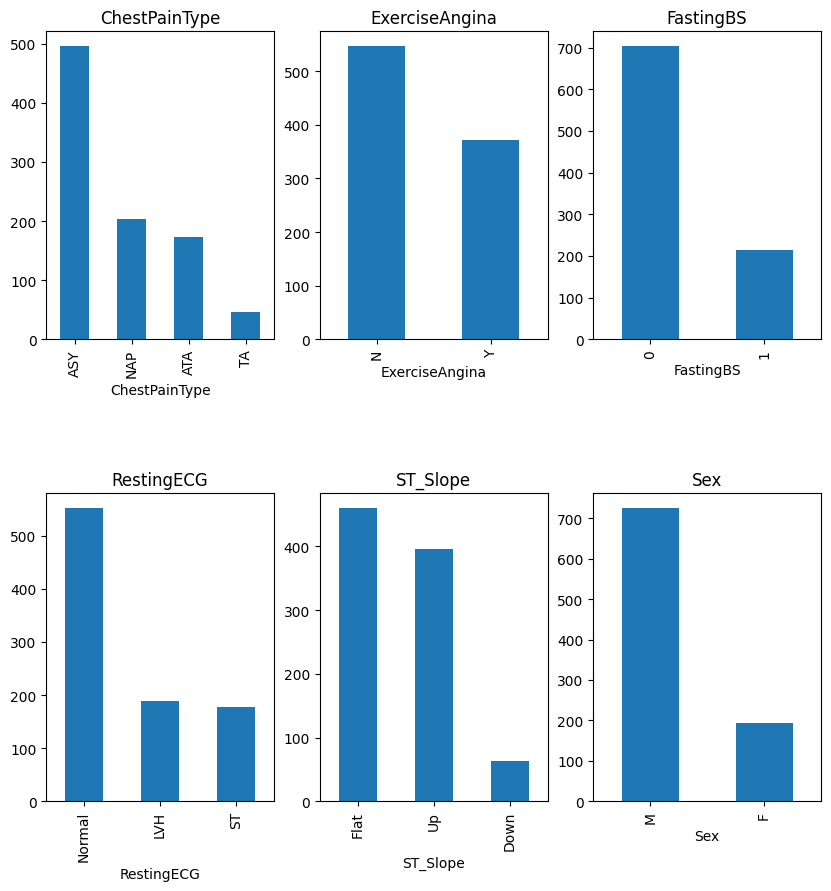

In [168]:
#-------- plot continuous features
CONTINUOUS_FEATURES = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
df[CONTINUOUS_FEATURES].hist(figsize=(10, 10))

#-------- plot categorical features
CATEGORICAL_FEATURES = df.columns.difference(CONTINUOUS_FEATURES).difference(['HeartDisease'])
fig, axes = plt.subplots(2, 3, figsize=(10, 10))
axes = axes.flatten()
plt.subplots_adjust(hspace=0.5)
for i, feature in enumerate(CATEGORICAL_FEATURES):
    df[feature].value_counts().plot(kind='bar', ax=axes[i], title=feature, width=0.5)


<h2> 1.4 - Probability density function (groupd graphs)</h2>

array([[<Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
        <Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
        <Axes: ylabel='Density'>],
       [<Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
        <Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
        <Axes: ylabel='Density'>],
       [<Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
        <Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
        <Axes: ylabel='Density'>]], dtype=object)

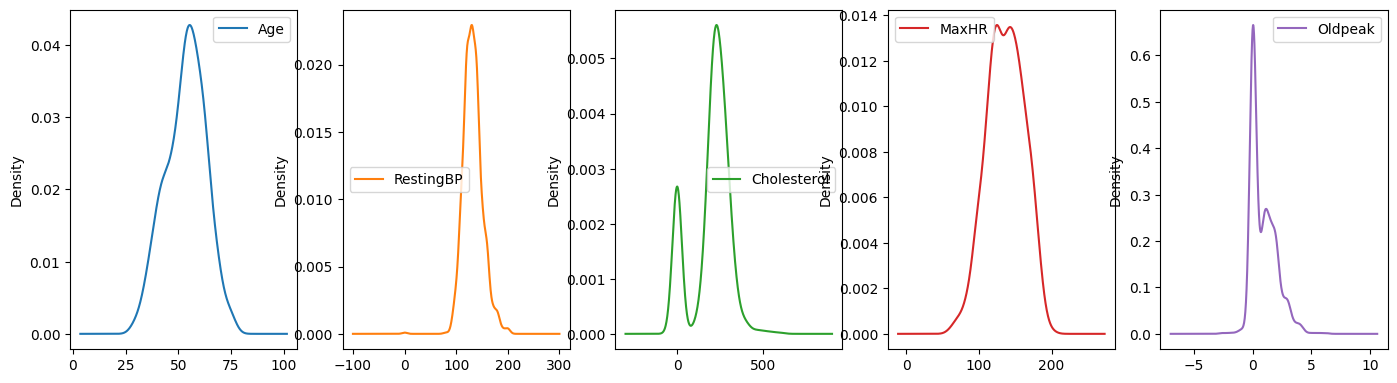

In [169]:
# plot the probability density function for each numerical feature
df[CONTINUOUS_FEATURES].plot(kind='density', subplots=True, layout=(3,5), sharex=False,figsize=(17,15))

<h2> 1.5 - Probability density function (individual graphs)</h2>

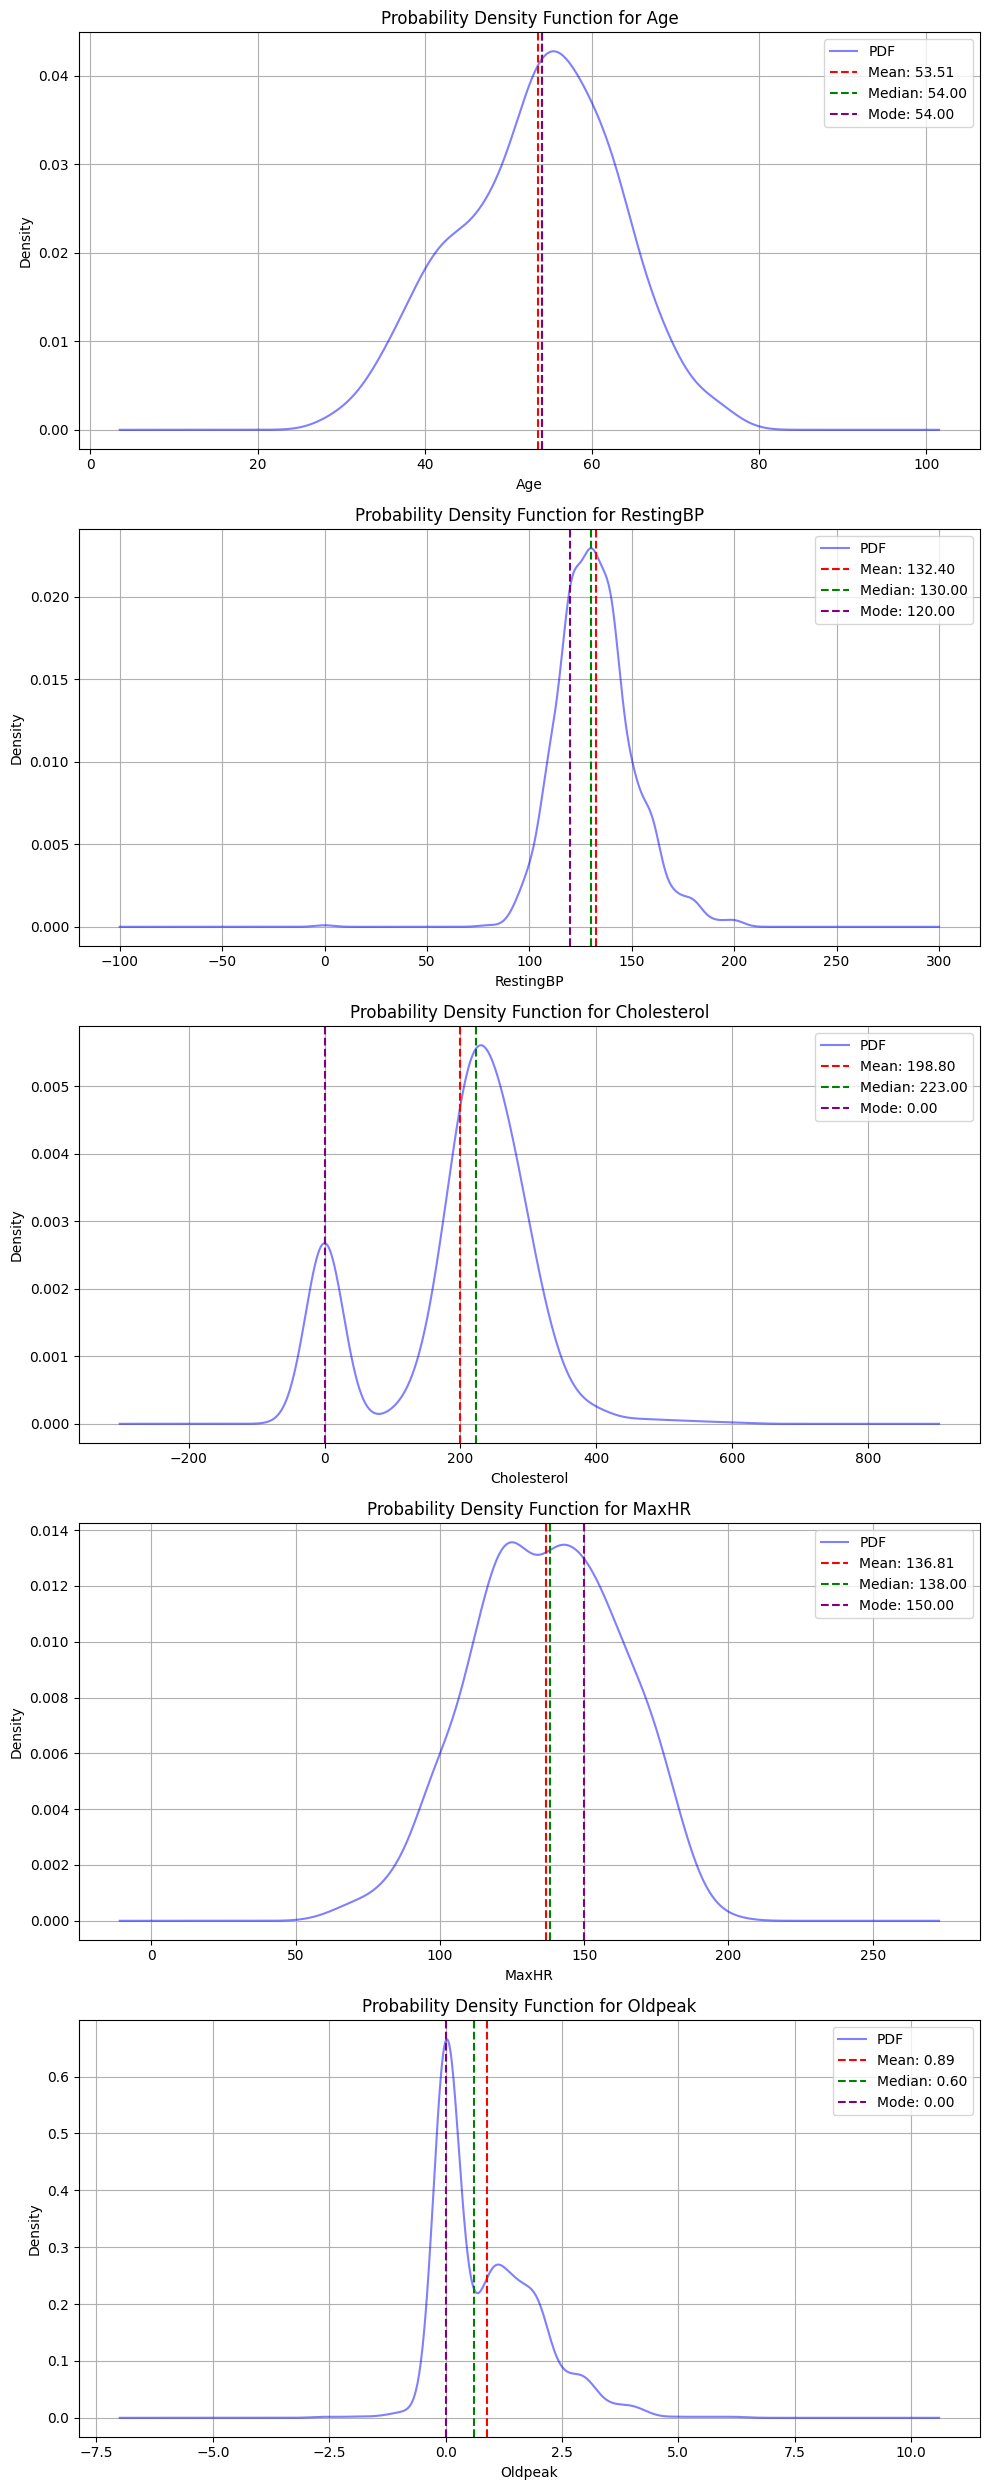

In [170]:
# (this cell does the same thing as the previous cell, but additionally display the mean, median and mode for each column)

num_features = len(CONTINUOUS_FEATURES)
fig, axes = plt.subplots(nrows=num_features, ncols=1, figsize=(10, 5 * num_features))

# Loop through each feature to create a PDF plot
for i, column in enumerate(CONTINUOUS_FEATURES):
    # Plotting the density
    df[column].plot(kind='density', ax=axes[i], color='blue', alpha=0.5, label='PDF')

    # Calculate mean, median, and mode
    mean = df[column].mean()
    median = df[column].median()
    mode = df[column].mode()[0]

    # Marking mean, median, and mode with horizontal lines
    axes[i].axvline(x=mean, color='red', linestyle='--', label=f'Mean: {mean:.2f}')  # Adjusted y-value for visibility
    axes[i].axvline(x=median, color='green', linestyle='--', label=f'Median: {median:.2f}')  # Adjusted y-value for visibility
    axes[i].axvline(x=mode, color='purple', linestyle='--', label=f'Mode: {mode:.2f}')  # Adjusted y-value for visibility

    # Adding titles and labels
    axes[i].set_title(f'Probability Density Function for {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Density')
    axes[i].legend()
    axes[i].grid()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

<h2> 1.6 - Skeweness</h2>

In [171]:
# plot the skewness for numerical features
df[CONTINUOUS_FEATURES].skew()

Age           -0.20
RestingBP      0.18
Cholesterol   -0.61
MaxHR         -0.14
Oldpeak        1.02
dtype: float64

<h2> 1.7 - Box plot</h3>

Age               Axes(0.125,0.747241;0.227941x0.132759)
RestingBP      Axes(0.398529,0.747241;0.227941x0.132759)
Cholesterol    Axes(0.672059,0.747241;0.227941x0.132759)
MaxHR             Axes(0.125,0.587931;0.227941x0.132759)
Oldpeak        Axes(0.398529,0.587931;0.227941x0.132759)
dtype: object

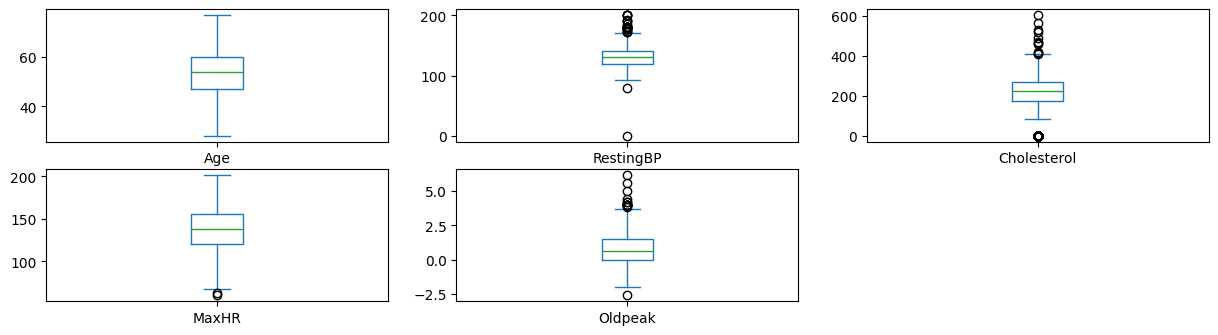

In [172]:
df[CONTINUOUS_FEATURES].plot(kind='box', subplots=True, sharex=False, sharey=False, layout=(5,3), figsize=(15,10))

<h1> 2 - Data cleaning and processing </h1>

<h2> 2.1 - Handling missing values </h2>

In [173]:
# Check for missing values in each column
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

Given that the dataset contains no missing values for any of the features, there was no need to perform replacement for missing values, dropping any rows with missing values, or dropping any features.

<h2> 2.2 - Remove Outliers </h2>

In [174]:
def remove_outliers(column):
    Q1 = np.percentile(column, 25)
    Q3 = np.percentile(column, 75)
    IQR = Q3 - Q1
    return column[(column >= Q1 - 1.5 * IQR) & (column <= Q3 + 1.5 * IQR)]

for column in CONTINUOUS_FEATURES:
    initial_count = df[column].count()
    df[column] = remove_outliers(df[column])
    final_count = df[column].count()
    print(f'{column}: was {initial_count} values, became {final_count}')


Age: was 918 values, became 918
RestingBP: was 918 values, became 890
Cholesterol: was 918 values, became 735
MaxHR: was 918 values, became 916
Oldpeak: was 918 values, became 902


<h2> 2.3 - Drop rows with Null values that resulted from outlier removal </h2>

In [175]:
df.dropna(subset=CONTINUOUS_FEATURES, inplace=True)
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,702.00,702.00,702.00,702.00,702.00,702.00,702.00
mean,52.72,131.56,239.71,0.16,140.55,0.83,0.46
std,9.54,15.42,50.68,0.37,24.36,0.96,0.50
min,28.00,92.00,85.00,0.00,71.00,-0.10,0.00
25%,46.00,120.00,206.00,0.00,122.00,0.00,0.00
50%,54.00,130.00,235.00,0.00,140.00,0.40,0.00
75%,59.00,140.00,272.00,0.00,160.00,1.50,1.00
max,77.00,170.00,404.00,1.00,202.00,3.60,1.00


Dropping rows with null values that resulted reduced dataset size from 918 to 702 rows.

<h2> 2.4 - Deal with duplicates </h2>

In [176]:
num_duplicates = df.duplicated().sum()
print(f'Number of duplicates: {num_duplicates}')

Number of duplicates: 0


No duplicates were found in the dataset.

<h2> 2.5 - Feature scaling </h2>

We opt for Standardization becauase: These features have different units (e.g., mmHg, mg/dL) and wide ranges. Standardization ensures they are on a comparable scale (mean 0, standard deviation 1) while preserving the shape of the distribution.

In [177]:
sc = StandardScaler()
df[CONTINUOUS_FEATURES] = sc.fit_transform(df[CONTINUOUS_FEATURES])
df[CONTINUOUS_FEATURES]

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
0,-1.34,0.55,0.97,1.29,-0.87
1,-0.39,1.85,-1.18,0.63,0.18
2,-1.65,-0.10,0.85,-1.75,-0.87
3,-0.50,0.42,-0.51,-1.34,0.70
4,0.13,1.20,-0.88,-0.76,-0.87
...,...,...,...,...,...
913,-0.81,-1.40,0.48,-0.35,0.38
914,1.60,0.81,-0.92,0.02,2.68
915,0.45,-0.10,-2.15,-1.05,0.38
916,0.45,-0.10,-0.07,1.37,-0.87


<h1> 3 - Feature extraction & selection </h1>

<h2> 3.1 - Correlation </h2>

<h2> 3.1.1 - Correlation between numerical features</h2>

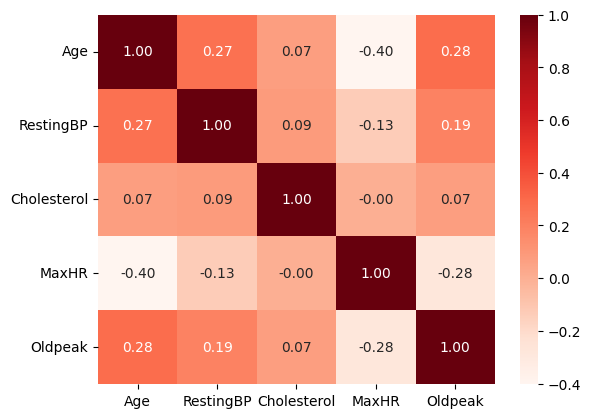

In [178]:
# numerical - numerical correlation
selected_df_corr = df.loc[:,CONTINUOUS_FEATURES]
correlation_matrix = selected_df_corr.corr()  # Calculate correlation matrix for numerical columns
sns.heatmap(correlation_matrix, cmap='Reds', annot=True, fmt='.2f')
plt.show()

The strongest correlation is between the features 'Age' and 'Oldpeak' (= 0.28), lets plot these 2 features to see the correlation better

<Axes: xlabel='Age', ylabel='Oldpeak'>

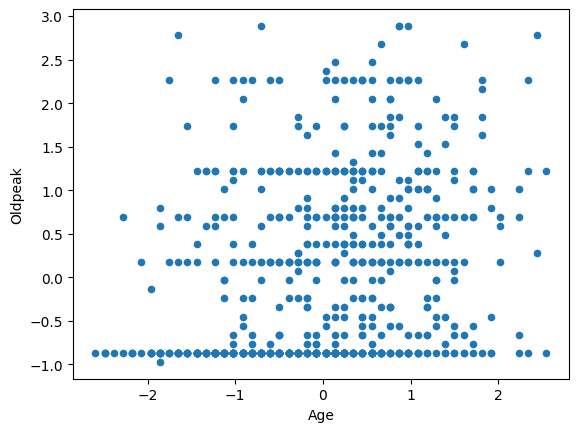

In [179]:
df.plot(kind='scatter', x='Age',y='Oldpeak')

From the plot, It is clear that there is no strong correlation between the features 'Age' and 'Oldpeak'.

Since the strongest correlation between any 2 numerical featurs = 0.28, which is cleary not strong from the graph, we decide not to exclude any of the features.

<h2> 3.1.2 - Correlation between categorical features</h2>

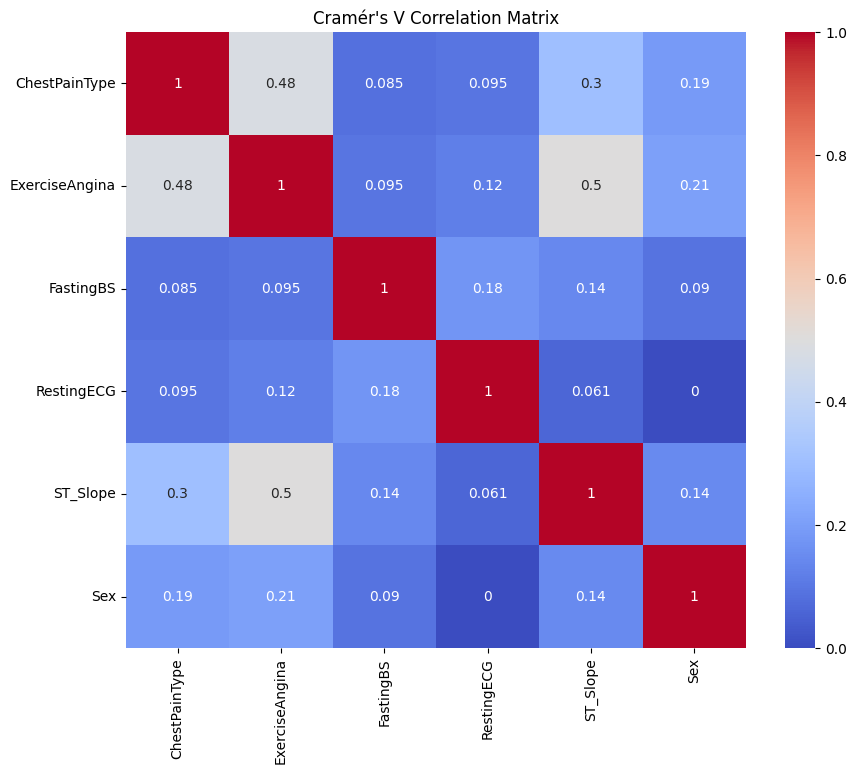

In [180]:
# Categorical - Categorical correlation
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

categorical_features = df.loc[:, CATEGORICAL_FEATURES]
corr_matrix = pd.DataFrame(np.zeros((len(categorical_features.columns), len(categorical_features.columns))), 
                           index=categorical_features.columns, columns=categorical_features.columns)

for col1 in categorical_features.columns:
    for col2 in categorical_features.columns:
        if col1 != col2:
            corr_matrix.loc[col1, col2] = cramers_v(categorical_features[col1], categorical_features[col2])
        else:
            corr_matrix.loc[col1, col2] = 1.0

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title('Cramér\'s V Correlation Matrix')
plt.show()

As we can see, the strongest correlation = 0.5 between (ST_Slope) & (ExerciseAngina) which is not strong enough to exclude any of them.

<h2> 3.1.3 - Correlation between numerical - categorical features</h2>

C:\Users\Dell\AppData\Local\Temp\ipykernel_19448\258967322.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return anova_table['sum_sq'][0] / anova_table['sum_sq'].sum()
C:\Users\Dell\AppData\Local\Temp\ipykernel_19448\258967322.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return anova_table['sum_sq'][0] / anova_table['sum_sq'].sum()
C:\Users\Dell\AppData\Local\Temp\ipykernel_19448\258967322.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, u

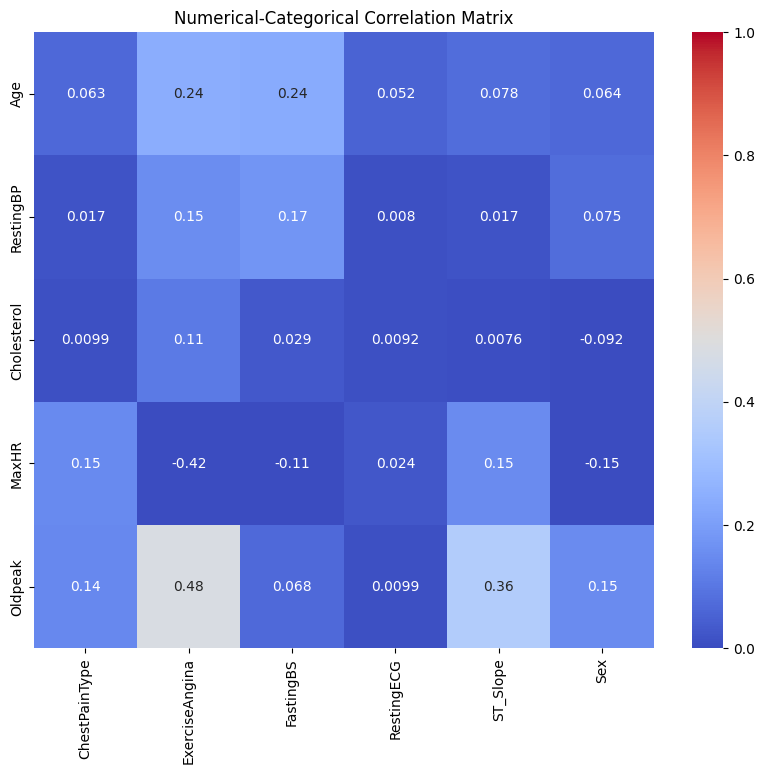

In [181]:

def eta_squared(anova_table):
    return anova_table['sum_sq'][0] / anova_table['sum_sq'].sum()

numerical_categorical_corr = pd.DataFrame(index=CONTINUOUS_FEATURES, columns=CATEGORICAL_FEATURES)

for cat_col in CATEGORICAL_FEATURES:
    if df[cat_col].nunique() == 2:  # Binary categorical variable
        # Convert binary categorical column to numerical values (0 and 1)
        df[cat_col] = df[cat_col].astype('category').cat.codes
        for num_col in CONTINUOUS_FEATURES:
            correlation, p_value = pointbiserialr(df[cat_col], df[num_col])
            numerical_categorical_corr.loc[num_col, cat_col] = correlation
    else:  # Categorical variable with more than two categories
        for num_col in CONTINUOUS_FEATURES:
            model = ols(f'{num_col} ~ C({cat_col})', data=df).fit()
            anova_table = sm.stats.anova_lm(model, typ=2)
            eta_sq = eta_squared(anova_table)
            numerical_categorical_corr.loc[num_col, cat_col] = eta_sq

# Display the numerical-categorical correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(numerical_categorical_corr.astype(float), annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title('Numerical-Categorical Correlation Matrix')
plt.show()

Again, the max correlation between numerical & categorical features = 0.48 between the (oldpeak) & (ExerciseAngina) which is not strong enough to exclude any of them.

<h2> 3.2 - Endocing Categorical Features </h2>

In [182]:
df = df.drop(columns=CATEGORICAL_FEATURES).join(pd.get_dummies(df[CATEGORICAL_FEATURES]))
df


,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,HeartDisease,ExerciseAngina,FastingBS,Sex,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,-1.34,0.55,0.97,1.29,-0.87,0,0,0,1,False,True,False,False,False,True,False,False,False,True
1,-0.39,1.85,-1.18,0.63,0.18,1,0,0,0,False,False,True,False,False,True,False,False,True,False
2,-1.65,-0.10,0.85,-1.75,-0.87,0,0,0,1,False,True,False,False,False,False,True,False,False,True
3,-0.50,0.42,-0.51,-1.34,0.70,1,1,0,0,True,False,False,False,False,True,False,False,True,False
4,0.13,1.20,-0.88,-0.76,-0.87,0,0,0,1,False,False,True,False,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,-0.81,-1.40,0.48,-0.35,0.38,1,0,0,1,False,False,False,True,False,True,False,False,True,False
914,1.60,0.81,-0.92,0.02,2.68,1,0,1,1,True,False,False,False,False,True,False,False,True,False
915,0.45,-0.10,-2.15,-1.05,0.38,1,1,0,1,True,False,False,False,False,True,False,False,True,False
916,0.45,-0.10,-0.07,1.37,-0.87,1,0,0,0,False,True,False,False,True,False,False,False,True,False


<h2> 3.3 PCA analysis </h2>

In [183]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(df.iloc[:, :-1])
pca_components = pd.DataFrame(data=pca_components, columns=['principal component 1', 'principal component 2'])
pca_df = pd.concat([pca_components, df[['HeartDisease']]], axis=1)

# Evaluate PCA
explained_variance_ratio = pca.explained_variance_ratio_
print(f'Reserved variance in each component: {[f"{var:.2f}" for var in explained_variance_ratio]}')
print(f"Total variance Reserved across all components: {np.sum(explained_variance_ratio):.2f}")

Reserved variance in each component: ['0.29', '0.14']
Total variance Reserved across all components: 0.43


<h1> 4 - Clustering </h1>

To help us deterime a good clustering technique, Lets plot PCA outputs

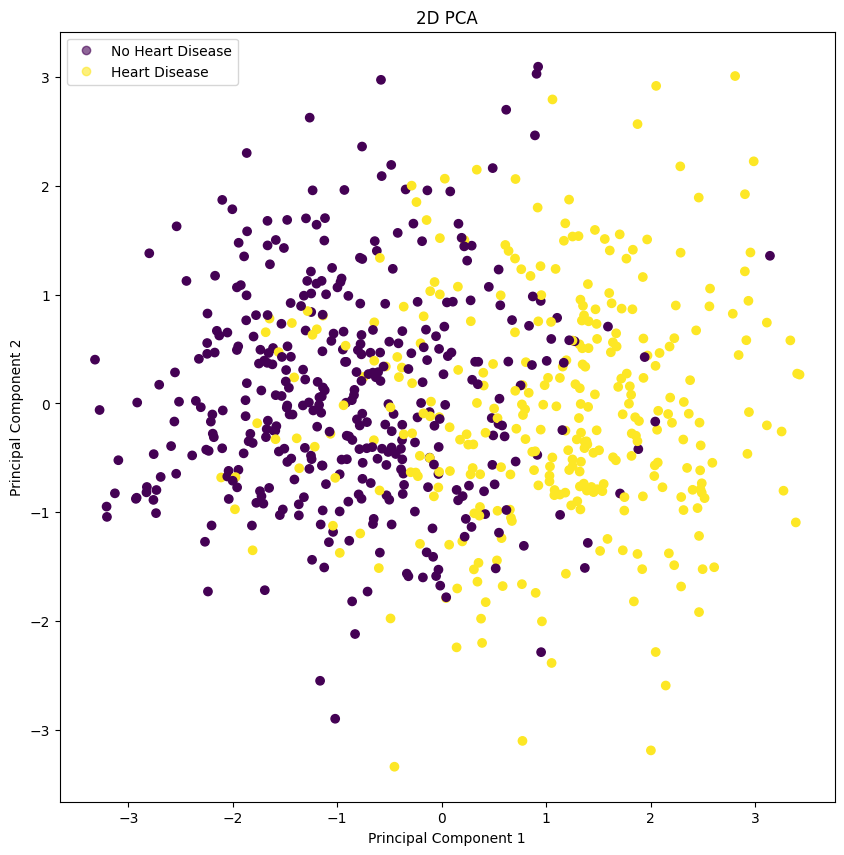

In [184]:
def plot_2d_pca(pca_components):
    plt.figure(figsize=(10, 10))
    scatter = plt.scatter(pca_components.iloc[:, 0], pca_components.iloc[:, 1], c=df['HeartDisease'], cmap='viridis')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('2D PCA')
    # Create custom legend
    handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
    legend_labels = ['No Heart Disease', 'Heart Disease']
    plt.legend(handles, legend_labels)
    plt.savefig(GROUND_TRUTH_CLUSTERS_FIG)
    plt.show()


def plot_3d_pca(pca_components):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(pca_components.iloc[:, 0], pca_components.iloc[:, 1], pca_components.iloc[:, 2], c=df['HeartDisease'], cmap='viridis')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    ax.set_title('3D PCA')
    # Create custom legend
    handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
    legend_labels = ['No Heart Disease', 'Heart Disease']
    ax.legend(handles, legend_labels)
    plt.savefig(GROUND_TRUTH_CLUSTERS_FIG)
    plt.show()
    
if pca_components.shape[1]  == 2:
    plot_2d_pca(pca_components)
elif pca_components.shape[1]  == 3:
    plot_3d_pca(pca_components)


We will try (K-means), (K-Mediods) & (Hierarchical clustering) algorithms and compare between them. To determine a good number of clusters for kmeans & kmedoids, we will use both the (Elbow method) & (Silhouette Coefficient)

<h2> 4.1 - K-means </h2>

<h3> 4.1.1 Choosing the right number of clusters using (Elbow Method) </h3>

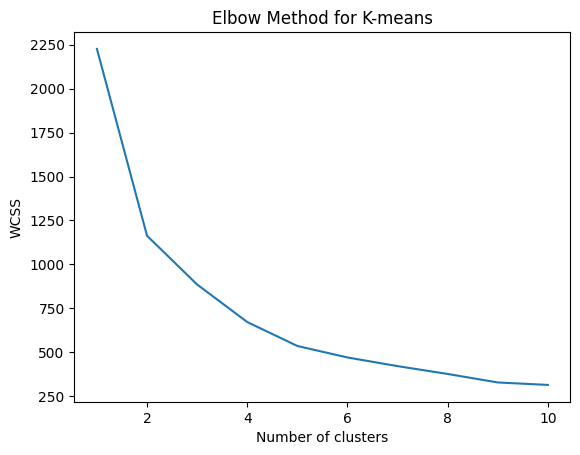

In [185]:
wcss = []
for i in range(1, 11):
    cluster_obj = KMeans(n_clusters=i, init='k-means++', random_state=RANDOM_STATE)
    cluster_obj.fit(pca_components)
    wcss.append(cluster_obj.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method for K-means')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()



As we can see from the graph of the elbow method with k-means, the optimal number of clusters is 2.

<h3> 4.1.2 Choosing the right number of clusters using (Silhouette Coefficient) </h3>

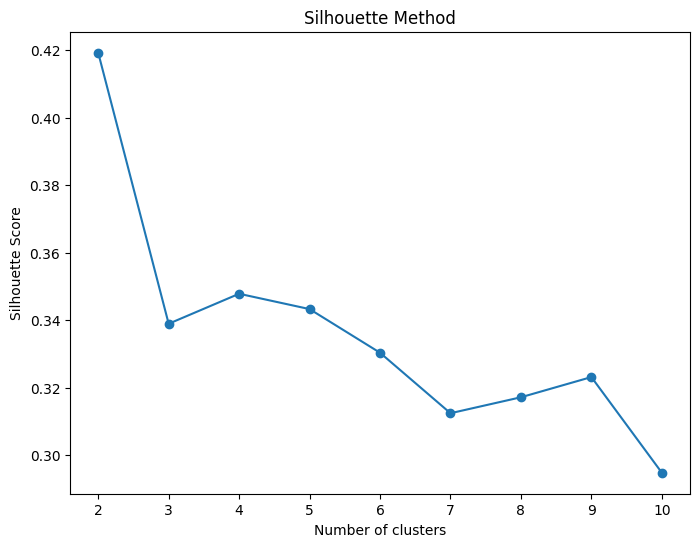

In [186]:
kmeans_silhouette_scores = []

range_n_clusters = list(range(2, 11))

for n_clusters in range_n_clusters:
    cluster_obj = KMeans(n_clusters=n_clusters, init='k-means++', random_state=RANDOM_STATE)
    cluster_obj.fit(pca_components)
    cluster_labels = cluster_obj.labels_
    silhouette_avg = silhouette_score(pca_components, cluster_labels)
    kmeans_silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(8, 6))
plt.plot(range_n_clusters, kmeans_silhouette_scores, marker='o')
plt.title('Silhouette Method')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

As we can see from the graph of silhouette score with k-means, the optimal number of clusters , is also 2. So for k-means, both elbow method & silhouette score agreed that the best k is 2

<h3> 4.1.3 - Perform & visualize k-means </h3>

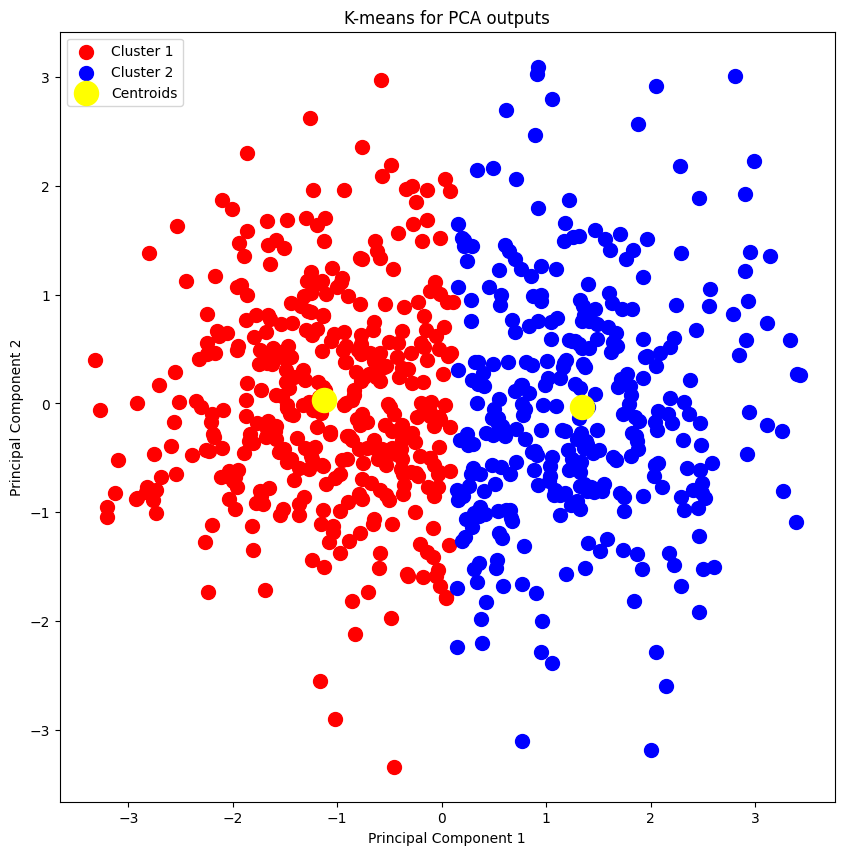

In [187]:
kmeans = KMeans(n_clusters=2, init='k-means++', random_state=RANDOM_STATE)
y = kmeans.fit_predict(pca_components)
display_clusters_plt(pca_components, y, kmeans, 'K-means for PCA outputs', KMEANS_FIG)


<h2> 4.2 - K-medoids </h2>

<h3> 4.2.1 Choosing the right number of clusters using (Elbow Method) </h3>

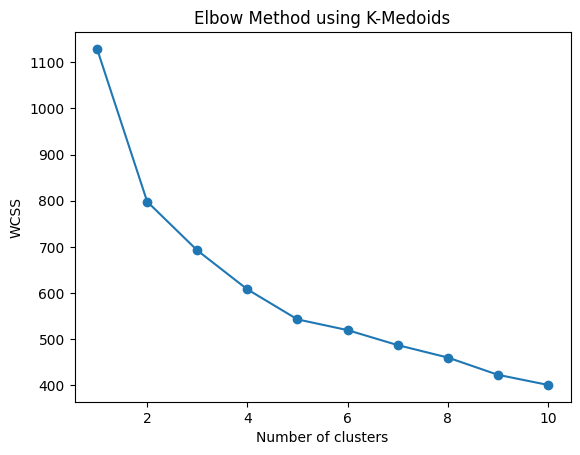

In [188]:
wcss = []
for i in range(1, 11):
    kmedoids = KMedoids(n_clusters=i, init='k-medoids++', random_state=RANDOM_STATE)
    kmedoids.fit(pca_components)
    wcss.append(kmedoids.inertia_)

plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method using K-Medoids')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

As we can see from the graph of the elbow method with k-medoids, the optimal number of clusters is 2 (just like the elbow-method with k-means)

<h3> 4.2.2 Choosing the right number of clusters using (Silhouette Coefficient) </h3>

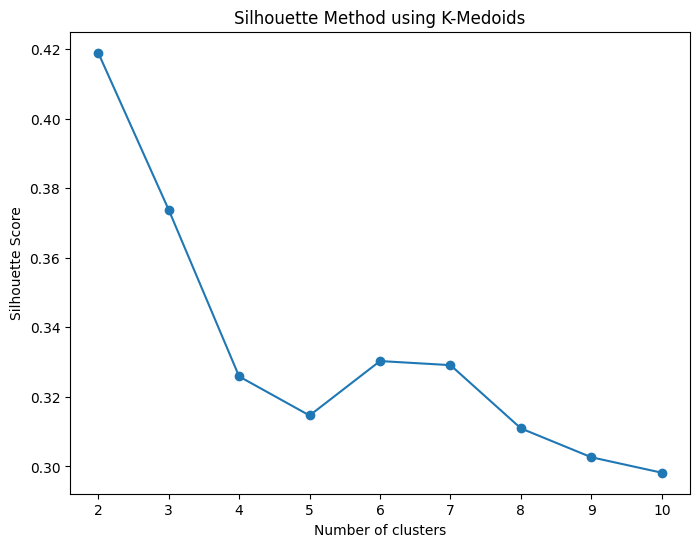

In [189]:
kmedoids_silhouette_scores = []

range_n_clusters = list(range(2, 11))

for n_clusters in range_n_clusters:
    kmedoids = KMedoids(n_clusters=n_clusters, random_state=RANDOM_STATE)
    kmedoids.fit(pca_components)
    cluster_labels = kmedoids.labels_
    silhouette_avg = silhouette_score(pca_components, cluster_labels)
    kmedoids_silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(8, 6))
plt.plot(range_n_clusters, kmedoids_silhouette_scores, marker='o')
plt.title('Silhouette Method using K-Medoids')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

As we can see from the graph of silhouette score with k-medoids, the optimal number of clusters is also 2. So both elbow method & silhouette score agreed that the best k is 2

<h3> 4.2.3 - Perform & visualize k-medoids </h3>

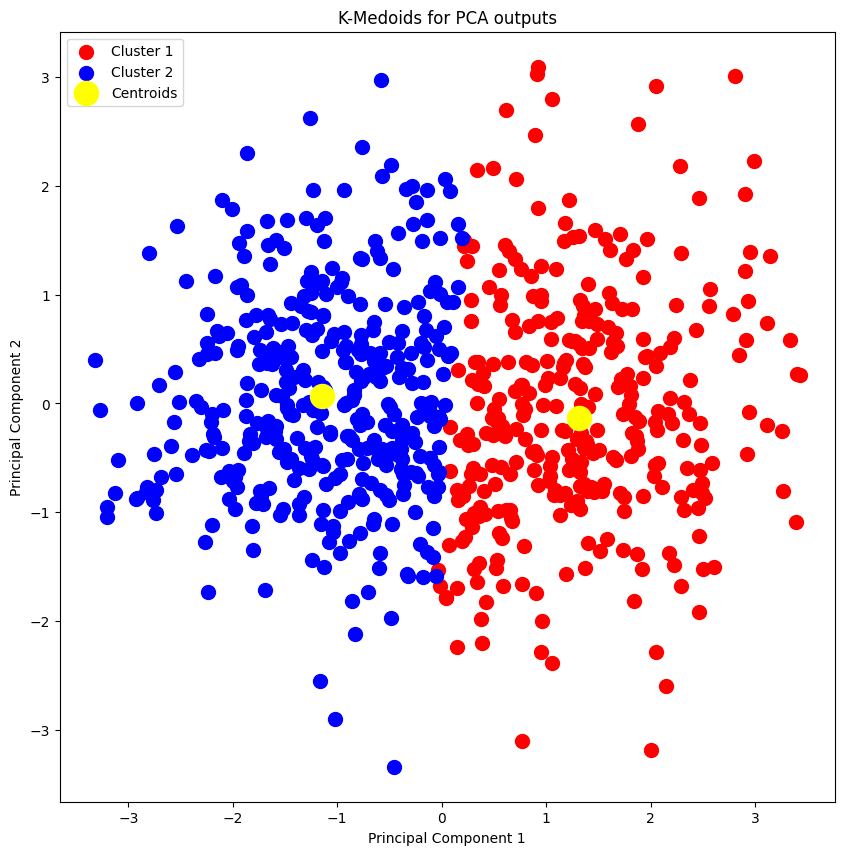

In [190]:
kmedoids = KMedoids(n_clusters=2, init='k-medoids++', random_state=RANDOM_STATE)
y_kmedoids = kmedoids.fit_predict(pca_components)
display_clusters_plt(pca_components, y_kmedoids, kmedoids, 'K-Medoids for PCA outputs', KMOIEDS_FIG)

We can see that both elbow method & silhouette score for both k-means & k-medoids agreed that the best number of clusters is 2. which is logical since the target feature (Heart Disease) has 2 classes as well.

<h2> 4.3 - Hierarchical clustering</h2>

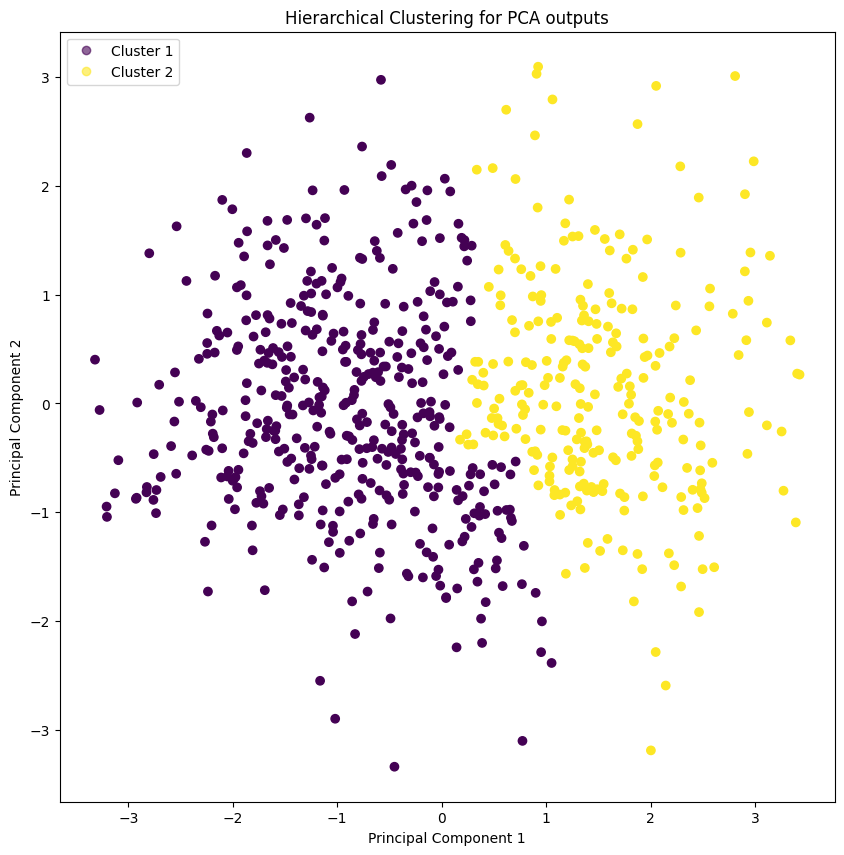

In [191]:
hierarchical_clustering = AgglomerativeClustering(n_clusters=2)
y_hierarchical = hierarchical_clustering.fit_predict(pca_components)

# Plot the clusters
def display_hierarchical_clusters_for_2d(pca_components, y_hierarchical):
    plt.figure(figsize=(10, 10))
    scatter = plt.scatter(pca_components.iloc[:, 0], pca_components.iloc[:, 1], c=y_hierarchical, cmap='viridis')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('Hierarchical Clustering for PCA outputs')
    # Create custom legend
    handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
    legend_labels = ['Cluster 1', 'Cluster 2']
    plt.legend(handles, legend_labels)
    plt.savefig(AGGLOMERATIVE_FIG)
    plt.show()
def display_hierarchical_clusters_for_3d(pca_components, y_hierarchical):
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(pca_components.iloc[:, 0], pca_components.iloc[:, 1], pca_components.iloc[:, 2], c=y_hierarchical, cmap='viridis')
    ax.set_title('Hierarchical Clustering for PCA outputs')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    # Create custom legend  
    handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
    legend_labels = ['Cluster 1', 'Cluster 2']
    ax.legend(handles, legend_labels)
    plt.savefig(AGGLOMERATIVE_FIG)
    plt.show()
if pca_components.shape[1] == 2:
    display_hierarchical_clusters_for_2d(pca_components, y_hierarchical)
elif pca_components.shape[1] == 3:
    display_hierarchical_clusters_for_3d(pca_components, y_hierarchical)

<h2> Comparison & evaluation of clustering will come in section 6 of the notebook</h2>

<h1> 5 - Classification </h1>

We will try 3 different models, and will train every model once with the original dataset, and once with the pca outputs & compare the results. Cross validation will be used to test performance. <br><br> The models are: <br><br> 1 - Logistic Regression <br><br> 2 - Decision Tree <br><br> 3 - Random Forest

<h2> Hyperparameters </h2>

In [192]:
num_folds = 10
num_of_trees_in_forest = 100

<h2> Functions & Global variables</h2>

In [193]:
original_features = df.drop(columns='HeartDisease')
target = df['HeartDisease']

def evaluate_model_cv(model, X, y, num_folds):
    skf = StratifiedKFold(n_splits=num_folds)
    train_f1_scores = []
    val_f1_scores = []
    # convert X , y to numpy array
    X = np.array(X)
    y = np.array(y)
    for train_index, val_index in skf.split(X, y):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)
        
        train_f1 = f1_score(y_train, y_train_pred)
        val_f1 = f1_score(y_val, y_val_pred)

        train_f1_scores.append(train_f1)
        val_f1_scores.append(val_f1)

    accuracy = cross_val_score(model, X, y, cv=num_folds, scoring='accuracy').mean()
    precision = cross_val_score(model, X, y, cv=num_folds, scoring='precision').mean()
    recall = cross_val_score(model, X, y, cv=num_folds, scoring='recall').mean()
    f1 = np.mean(val_f1_scores)
    return accuracy, precision, recall, f1

def print_results(model_name, results):
    accuracy, precision, recall, f1 = results
    print(f"{model_name} \nAccuracy: {accuracy:.2f} \nPrecision: {precision:.2f} \nRecall: {recall:.2f} \nF1 Score: {f1:.2f}")
    print("Above are mean values for each metric on test set\n")



<h2> 5.1 - Logistic Regression </h2>

In [194]:
logistic_regression = LogisticRegression(random_state=RANDOM_STATE)
reg_original_data_results = evaluate_model_cv(logistic_regression, original_features, target, num_folds)
print_results('Logistic Regression - Original Data', reg_original_data_results)
reg_pca_data_results = evaluate_model_cv(logistic_regression, pca_components, target , num_folds)
print_results('Logistic Regression - PCA Data', reg_pca_data_results)

Logistic Regression - Original Data 
Accuracy: 0.86 
Precision: 0.85 
Recall: 0.86 
F1 Score: 0.85
Above are mean values for each metric on test set

Logistic Regression - PCA Data 
Accuracy: 0.80 
Precision: 0.81 
Recall: 0.78 
F1 Score: 0.78
Above are mean values for each metric on test set



We can see that all metrics are better when using the original dataset compared to the PCA outputs, which is expected since the total variance reserved across all PCA components = 0.43 (check section 3.3), which is not good enough.

<h2> 5.2 - Decision Tree </h2>

In [195]:

decision_tree = DecisionTreeClassifier(random_state=RANDOM_STATE)
tree_original_results = evaluate_model_cv(decision_tree, original_features, target, num_folds)
print_results("Decision Tree - Original data", tree_original_results)
tree_pca_results = evaluate_model_cv(decision_tree, pca_components, target, num_folds)
print_results("Decision Tree - PCA data", tree_pca_results)

Decision Tree - Original data 
Accuracy: 0.79 
Precision: 0.79 
Recall: 0.76 
F1 Score: 0.77
Above are mean values for each metric on test set

Decision Tree - PCA data 
Accuracy: 0.73 
Precision: 0.72 
Recall: 0.73 
F1 Score: 0.71
Above are mean values for each metric on test set



Similar to the logistic regression, all metrics are better when using the original dataset compared to the PCA outputs. 

<h2> 5.3 - Random Forest </h2>


In [196]:
random_forest = RandomForestClassifier(n_estimators = num_of_trees_in_forest, random_state=RANDOM_STATE)
forest_original_results = evaluate_model_cv(random_forest, original_features, target, num_folds)
print_results("Random Forest - Original data", forest_original_results)
forest_pca_results = evaluate_model_cv(random_forest, pca_components, target, num_folds)
print_results("Random Forest - PCA data", forest_pca_results)

Random Forest - Original data 
Accuracy: 0.86 
Precision: 0.85 
Recall: 0.86 
F1 Score: 0.85
Above are mean values for each metric on test set

Random Forest - PCA data 
Accuracy: 0.77 
Precision: 0.78 
Recall: 0.74 
F1 Score: 0.75
Above are mean values for each metric on test set



Again, Similar to logistic regression & decision tree, all metrics are better when using the original dataset compared to the PCA outputs.

<h1> 6 - Comparisons </h1>

<h2> 6.1 - Comparison between clustering techniques </h2>

<h2> Compare using visualizations </h2>

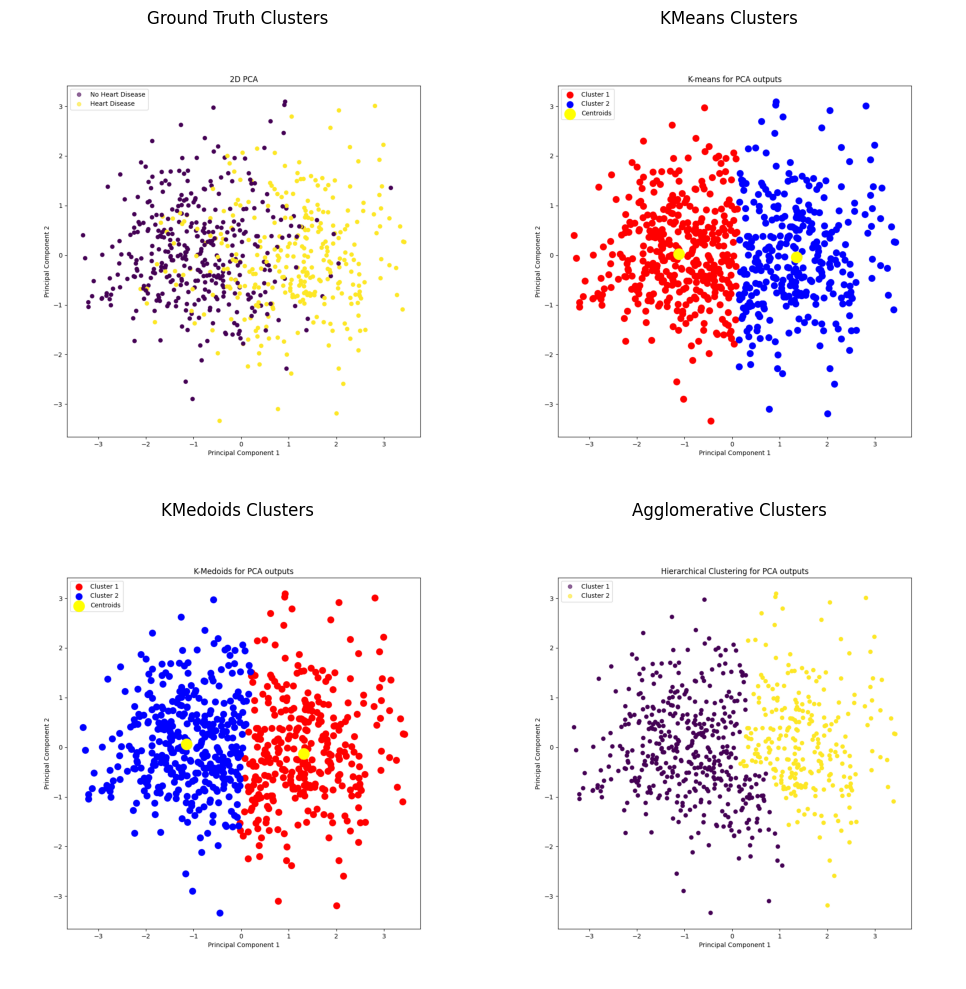

In [197]:
# display the 4 plots in a 2 * 2 grid
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
images_files = [GROUND_TRUTH_CLUSTERS_FIG, KMEANS_FIG, KMOIEDS_FIG, AGGLOMERATIVE_FIG]
titles = ['Ground Truth Clusters', 'KMeans Clusters', 'KMedoids Clusters', 'Agglomerative Clusters']
for i, ax in enumerate(axes.flat):
    img = plt.imread(images_files[i])
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(titles[i])
plt.tight_layout()
plt.show()


<h2> Compare using Adjusted Rand Index (ARI) & Normalized Mutual Information (NMI) </h2>

In [198]:

ari_hierarchical = adjusted_rand_score(target, y_hierarchical)
nmi_hierarchical = normalized_mutual_info_score(target, y_hierarchical)

ari_kmedoids = adjusted_rand_score(target, y_kmedoids)
nmi_kmedoids = normalized_mutual_info_score(target, y_kmedoids)

ari_kmeans = adjusted_rand_score(target, y)
nmi_kmeans = normalized_mutual_info_score(target, y)

print(f"KMeans - ARI: {ari_kmeans:.2f}, NMI: {nmi_kmeans:.2f}")
print(f"KMedoids - ARI: {ari_kmedoids:.2f}, NMI: {nmi_kmedoids:.2f}")
print(f"Hierarchical Clustering - ARI: {ari_hierarchical:.2f}, NMI: {nmi_hierarchical:.2f}")


KMeans - ARI: 0.38, NMI: 0.29
KMedoids - ARI: 0.38, NMI: 0.30
Hierarchical Clustering - ARI: 0.34, NMI: 0.27


We can see that partitionnal clustering (kmeans & kmedoids) has the highest ARI & NMI scores, which means partitionnal clustering is better than hierarchical one for this dataset. We can also notice that ARI & NMI scores for kmeans & kmedoids are almost the same.

<h2> 6.2 - Comparison between supervised learning models </h2>

<h2> Comparison using accuracy, prec, recall & f1 score </h2>

In [199]:
# Create a DataFrame with multi-level columns
columns = pd.MultiIndex.from_product(
    [['Logistic Regression', 'Decision Tree', 'Random Forest'],
     ['Accuracy', 'Precision', 'Recall', 'F1 Score']]
)

# Create the DataFrame
results_df = pd.DataFrame(index=['Original Dataset', 'PCA Outputs'], columns=columns)

# Define the models and their results
models = ['Logistic Regression', 'Decision Tree', 'Random Forest']
results = {
    'Logistic Regression': [reg_original_data_results, reg_pca_data_results],
    'Decision Tree': [tree_original_results, tree_pca_results],
    'Random Forest': [forest_original_results, forest_pca_results]
}

# Populate the DataFrame with the results using a loop
for model in models:
    for i, dataset in enumerate(['Original Dataset', 'PCA Outputs']):
        results_df.loc[dataset, (model, 'Accuracy')] = results[model][i][0]
        results_df.loc[dataset, (model, 'Precision')] = results[model][i][1]
        results_df.loc[dataset, (model, 'Recall')] = results[model][i][2]
        results_df.loc[dataset, (model, 'F1 Score')] = results[model][i][3]

styled_df = results_df.style.set_properties(**{'text-align': 'center'}).set_table_styles([{
    'selector': 'th',
    'props': [('text-align', 'center')]
}]).format(precision=2)

# Remove all rows except the first 2 rows of data and their headers
styled_df.data = styled_df.data[0:2]

styled_df

As we can see from the table, the logistic regression & the random forest metricies are equal when trained on the original dataset, (acc = 0.86, prec = 0.85, recall = 0.86, f1 = 0.85), but the logistic regression is slightly better when trained on the PCA outputs. The decision tree is the worst among the 3 models.

<h2> Compare using decision boundary visualization </h2>

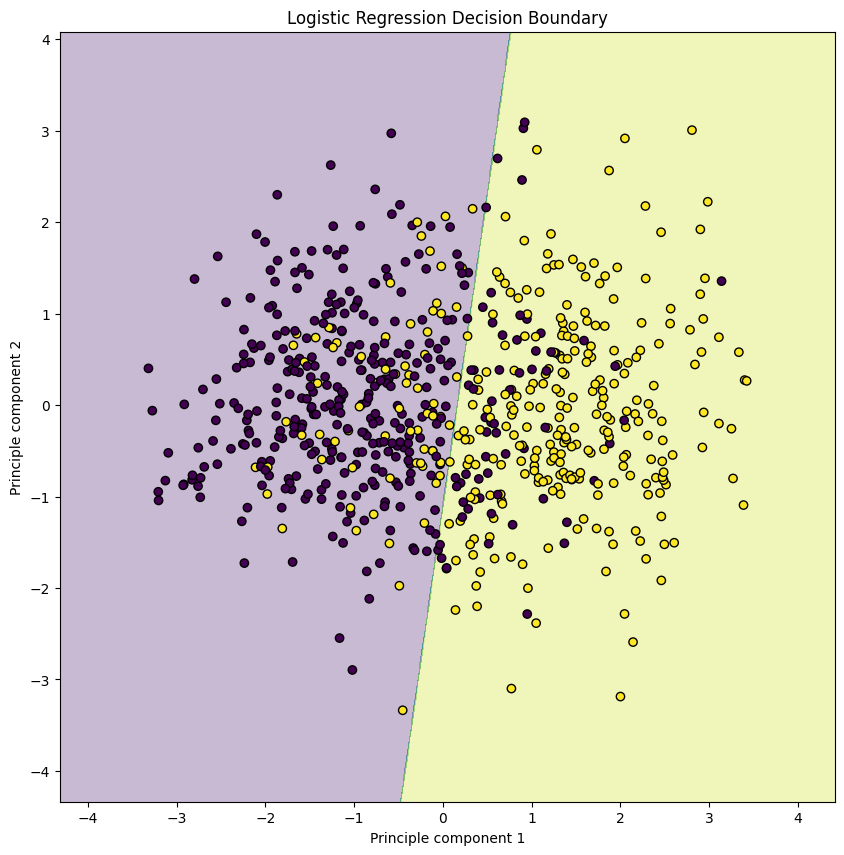

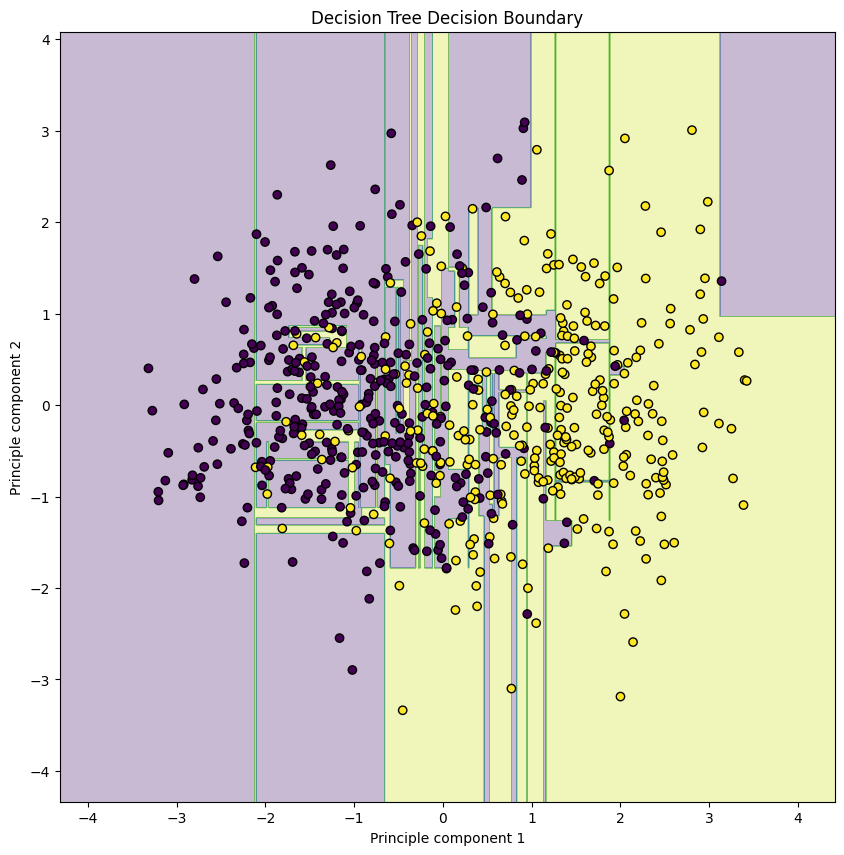

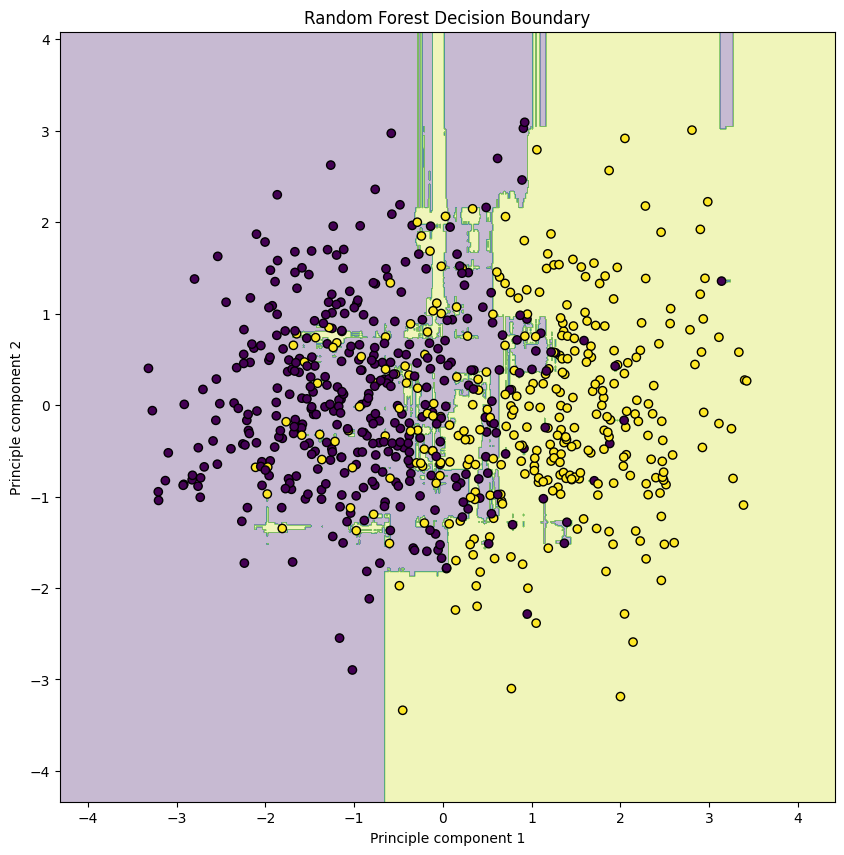

In [200]:
def plot_decision_boundary_2d(model, X, y, title):
    
    model.fit(X, y)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    
    # Create a mesh grid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    
    # Predict on the mesh grid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot decision boundary
    ax.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
    
    # Plot original data points
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o')
    
    ax.set_title(title)
    ax.set_xlabel('Principle component 1')
    ax.set_ylabel('Principle component 2')
    plt.show()

# Convert pca_components to a NumPy array
pca_components_array = pca_components.values

plot_decision_boundary_2d(logistic_regression, pca_components_array, target, 'Logistic Regression Decision Boundary')
plot_decision_boundary_2d(decision_tree, pca_components_array, target, 'Decision Tree Decision Boundary')
plot_decision_boundary_2d(random_forest, pca_components_array, target, 'Random Forest Decision Boundary')

<h1> Discussion and Future Insights </h1>

### Conclusion:
1 - Logistic regression & random forest metricies are approximately equal for original dataset. <br>
2 - Decision tree was the worst.<br>
3 - PCA reduced the performance of all models.<br>
4 - Partitional clustering was better than hierarchical one.<br>

### Future Insights:
To improve the performance of the models, we can: <br>
1 - Increase dataset size.<br>
2 - Try different models (such as SVM).<br>
3 - Decrease the number of features.<br>